# 使用PyTorch Ignite训练GAN生成Atari游戏画面

本notebook实现了一个生成对抗网络(GAN)，使用PyTorch Ignite框架来训练和生成类似Atari游戏的图像。我们将使用Gymnasium库中的几个Atari游戏环境作为训练数据。

## 导入必要的库

In [45]:
import random
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import tensorboard_logger as tb_logger

import torchvision.utils as vutils
import gymnasium as gym
from gymnasium import spaces

import numpy as np
import matplotlib.pyplot as plt

log = gym.logger
log.set_level(gym.logger.INFO)

## 设置超参数

定义模型训练和生成过程中需要的各种参数。

In [46]:
LATENT_VECTOR_SIZE = 100  # 潜在向量的大小
DISCR_FILTERS = 64        # 判别器中的基础卷积滤波器数量
GENER_FILTERS = 64        # 生成器中的基础卷积滤波器数量
BATCH_SIZE = 16           # 批次大小

# 输入图像将被缩放的尺寸
IMAGE_SIZE = 64

LEARNING_RATE = 0.0001    # 学习率
REPORT_EVERY_ITER = 1000   # 每多少次迭代报告一次训练状态
SAVE_IMAGE_EVERY_ITER = 10000  # 每多少次迭代保存一次生成的图像

## 输入预处理包装器

创建一个Gymnasium环境包装器，用于预处理输入图像：
1. 将图像调整为预定义的大小
2. 将颜色通道轴移到第一位置(从HWC格式转为CHW格式)

In [47]:
class InputWrapper(gym.ObservationWrapper):
    """
    输入numpy数组的预处理：
    1. 将图像调整为预定义的大小
    2. 将颜色通道轴移到第一位置
    """
    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)
        old_space = self.observation_space
        assert isinstance(old_space, spaces.Box)
        self.observation_space = gym.spaces.Box(self.observation(old_space.low), 
                                                self.observation(old_space.high),
                                                dtype=np.float32)

    def observation(self, observation):
        # 调整图像大小
        new_obs = cv2.resize(observation, (IMAGE_SIZE, IMAGE_SIZE))
        # 转换 (w, h, c) -> (c, w, h)
        new_obs = np.moveaxis(new_obs, 2, 0)
        return new_obs.astype(np.float32)

## 判别器模型

判别器网络接收一个图像作为输入，并输出一个表示该图像是真实的(接近1)还是生成的(接近0)的概率值。

In [48]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        # 这个管道将图像转换为单个数字
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=DISCR_FILTERS,
                      kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS, out_channels=DISCR_FILTERS*2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 2, out_channels=DISCR_FILTERS * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 4, out_channels=DISCR_FILTERS * 8,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 8, out_channels=1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)

## 生成器模型

生成器网络接收一个随机潜在向量作为输入，并生成一个与训练数据相似的图像。

In [49]:
class Generator(nn.Module):
    def __init__(self, output_shape):
        super(Generator, self).__init__()
        # 管道将输入向量反卷积成 (3, 64, 64) 图像
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=GENER_FILTERS * 8,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(GENER_FILTERS * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 8, out_channels=GENER_FILTERS * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 4, out_channels=GENER_FILTERS * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 2, out_channels=GENER_FILTERS,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS, out_channels=output_shape[0],
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)

## 批次迭代器

创建一个函数，从Atari游戏环境中收集观察数据，并将它们组织成批次。

In [50]:
def iterate_batches(envs, batch_size=BATCH_SIZE):
    batch = [e.reset()[0] for e in envs]
    env_gen = iter(lambda: random.choice(envs), None)

    while True:
        e = next(env_gen)
        obs, reward, is_done, is_trunc, _ = e.step(e.action_space.sample())
        if np.mean(obs) > 0.01:  # 过滤掉全黑的图像
            batch.append(obs)
        if len(batch) == batch_size:
            # 将输入归一化到[-1..1]并转换为张量
            batch_np = np.array(batch, dtype=np.float32)
            yield torch.tensor(batch_np * 2.0 / 255.0 - 1.0)
            batch.clear()
        if is_done or is_trunc:
            e.reset()

## 设置环境和模型

初始化游戏环境、模型和优化器。

In [51]:
# 设置设备（CPU或GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建游戏环境
envs = [InputWrapper(gym.make(name)) for name in ('Breakout-v4', 'AirRaid-v4', 'Pong-v4')]
input_shape = envs[0].observation_space.shape
print(f"观察空间形状: {input_shape}")

# 初始化判别器和生成器
net_discr = Discriminator(input_shape=input_shape).to(device)
net_gener = Generator(output_shape=input_shape).to(device)

# 设置损失函数和优化器
objective = nn.BCELoss()
gen_optimizer = optim.Adam(params=net_gener.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(params=net_discr.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# 准备标签
true_labels_v = torch.ones(BATCH_SIZE, device=device)
fake_labels_v = torch.zeros(BATCH_SIZE, device=device)

使用设备: cuda
观察空间形状: (3, 64, 64)


## 定义训练过程

使用PyTorch Ignite框架定义训练过程，包括批处理函数和事件处理程序。

In [52]:
def process_batch(trainer, batch):
    """
    处理一个批次的数据，训练判别器和生成器
    """
    # 生成随机潜在向量
    gen_input_v = torch.FloatTensor(BATCH_SIZE, LATENT_VECTOR_SIZE, 1, 1)
    gen_input_v.normal_(0, 1)  # 用正态分布初始化
    gen_input_v = gen_input_v.to(device)
    batch_v = batch.to(device)
    gen_output_v = net_gener(gen_input_v)

    # 训练判别器
    dis_optimizer.zero_grad()
    dis_output_true_v = net_discr(batch_v)
    dis_output_fake_v = net_discr(gen_output_v.detach())
    dis_loss = objective(dis_output_true_v, true_labels_v) + \
               objective(dis_output_fake_v, fake_labels_v)
    dis_loss.backward()
    dis_optimizer.step()

    # 训练生成器
    gen_optimizer.zero_grad()
    dis_output_v = net_discr(gen_output_v)
    gen_loss = objective(dis_output_v, true_labels_v)
    gen_loss.backward()
    gen_optimizer.step()

    # 定期保存生成的图像
    if trainer.state.iteration % SAVE_IMAGE_EVERY_ITER == 0:
        fake_img = vutils.make_grid(gen_output_v.data[:64], normalize=True)
        trainer.tb.writer.add_image("fake", fake_img, trainer.state.iteration)
        real_img = vutils.make_grid(batch_v.data[:64], normalize=True)
        trainer.tb.writer.add_image("real", real_img, trainer.state.iteration)
        trainer.tb.writer.flush()
        
        # 显示生成的和真实的图像
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 1, 1)
        plt.title("Generated Images: ")
        plt.imshow(np.transpose(fake_img.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        
        plt.subplot(2, 1, 2)
        plt.title("Ground Truth Images: ")
        plt.imshow(np.transpose(real_img.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()
    
    return dis_loss.item(), gen_loss.item()

## 设置Ignite引擎和TensorBoard记录器

配置PyTorch Ignite引擎，添加指标和处理程序。

In [53]:
# 创建Ignite引擎
engine = Engine(process_batch)

# 设置TensorBoard记录器
tb = tb_logger.TensorboardLogger(log_dir="runs/atari_gan")
engine.tb = tb

# 添加运行平均指标
RunningAverage(output_transform=lambda out: out[1]).attach(engine, "avg_loss_gen")
RunningAverage(output_transform=lambda out: out[0]).attach(engine, "avg_loss_dis")

# 将指标添加到TensorBoard
handler = tb_logger.OutputHandler(tag="train", metric_names=['avg_loss_gen', 'avg_loss_dis'])
tb.attach(engine, log_handler=handler, event_name=Events.ITERATION_COMPLETED)

# 添加计时器
timer = Timer()
timer.attach(engine)

## 添加日志记录事件处理程序

添加事件处理程序，定期记录训练进度和损失值。

In [54]:
@engine.on(Events.ITERATION_COMPLETED)
def log_losses(trainer):
    """记录损失值和训练进度"""
    if trainer.state.iteration % REPORT_EVERY_ITER == 0:
        log.info("%d 在 %.2f秒内完成: 生成器损失=%f, 判别器损失=%f",
                 trainer.state.iteration, timer.value(),
                 trainer.state.metrics['avg_loss_gen'],
                 trainer.state.metrics['avg_loss_dis'])
        timer.reset()

## 添加早期停止和模型保存处理程序

设置处理程序，在训练过程中定期保存模型，并在达到最大迭代次数时停止训练。

In [55]:
from ignite.handlers import ModelCheckpoint, TerminateOnNan

# 添加模型保存处理程序
checkpoint_handler = ModelCheckpoint('checkpoints', 'gan', n_saved=3, require_empty=False)
engine.add_event_handler(Events.ITERATION_COMPLETED(every=5000), checkpoint_handler, {
    'generator': net_gener,
    'discriminator': net_discr
})

# 添加NaN检测处理程序
engine.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

# 设置最大迭代次数
max_iterations = 50000

@engine.on(Events.ITERATION_COMPLETED)
def stop_training(engine):
    """在达到最大迭代次数时停止训练"""
    if engine.state.iteration >= max_iterations:
        engine.terminate()

## 运行训练过程

启动训练引擎，开始训练GAN模型。

INFO: 1000 在 14.24秒内完成: 生成器损失=7.660432, 判别器损失=0.163239
INFO: 2000 在 14.39秒内完成: 生成器损失=6.972462, 判别器损失=0.326363
INFO: 3000 在 14.03秒内完成: 生成器损失=6.806682, 判别器损失=0.272260
INFO: 4000 在 14.14秒内完成: 生成器损失=8.310321, 判别器损失=0.006900
INFO: 5000 在 14.15秒内完成: 生成器损失=6.036476, 判别器损失=0.196093
INFO: 6000 在 14.39秒内完成: 生成器损失=8.675416, 判别器损失=0.004566
INFO: 7000 在 14.06秒内完成: 生成器损失=7.186149, 判别器损失=0.021620
INFO: 8000 在 14.08秒内完成: 生成器损失=9.150484, 判别器损失=0.001986
INFO: 9000 在 14.17秒内完成: 生成器损失=7.006282, 判别器损失=0.051895


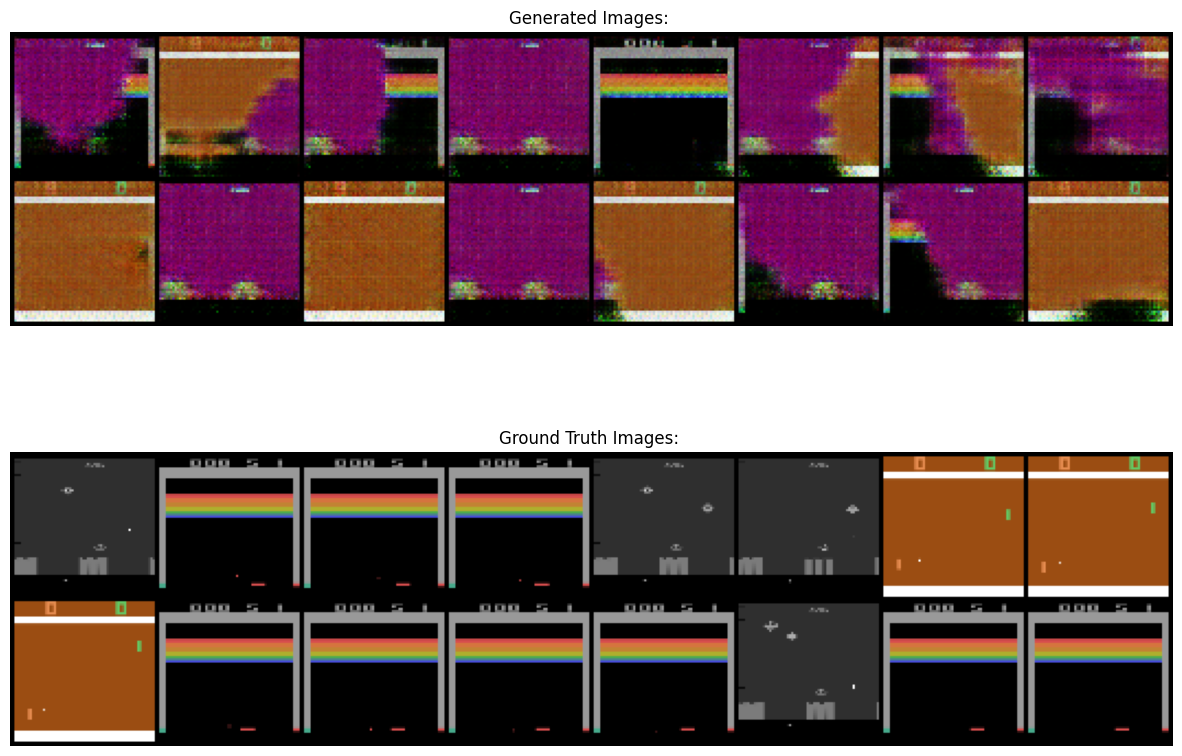

INFO: 10000 在 15.07秒内完成: 生成器损失=7.808809, 判别器损失=0.122590
INFO: 11000 在 14.06秒内完成: 生成器损失=6.000026, 判别器损失=0.138276
INFO: 12000 在 14.16秒内完成: 生成器损失=8.043365, 判别器损失=0.026022
INFO: 13000 在 14.31秒内完成: 生成器损失=6.837292, 判别器损失=0.319263
INFO: 14000 在 14.13秒内完成: 生成器损失=7.117588, 判别器损失=0.093182
INFO: 15000 在 14.31秒内完成: 生成器损失=7.534273, 判别器损失=0.002047
INFO: 16000 在 14.18秒内完成: 生成器损失=8.984162, 判别器损失=0.000518
INFO: 17000 在 14.18秒内完成: 生成器损失=9.704568, 判别器损失=0.000157
INFO: 18000 在 14.31秒内完成: 生成器损失=10.673912, 判别器损失=0.000065
INFO: 19000 在 14.32秒内完成: 生成器损失=11.090212, 判别器损失=0.000055


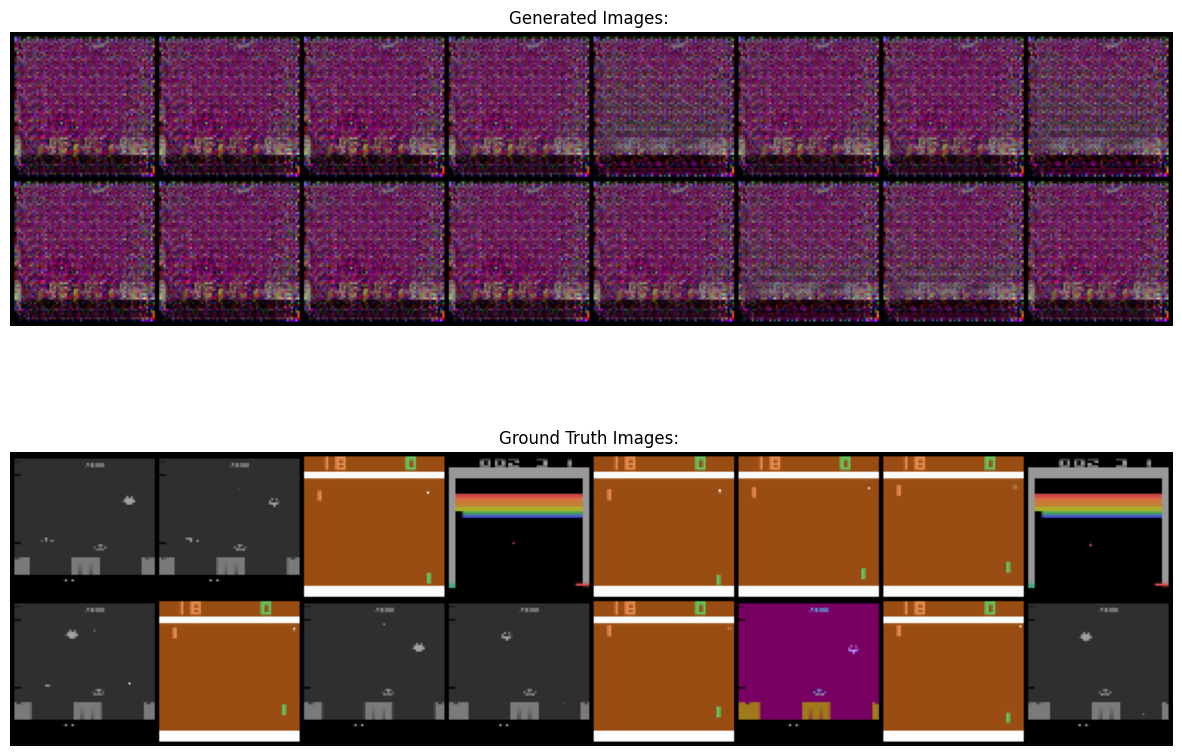

INFO: 20000 在 14.52秒内完成: 生成器损失=12.965072, 判别器损失=0.000007
INFO: 21000 在 14.01秒内完成: 生成器损失=7.603422, 判别器损失=0.014296
INFO: 22000 在 14.03秒内完成: 生成器损失=7.297347, 判别器损失=0.072744
INFO: 23000 在 14.29秒内完成: 生成器损失=10.074507, 判别器损失=0.020642
INFO: 24000 在 13.94秒内完成: 生成器损失=7.784027, 判别器损失=0.001705
INFO: 25000 在 14.21秒内完成: 生成器损失=7.013763, 判别器损失=0.023708
INFO: 26000 在 14.24秒内完成: 生成器损失=9.221552, 判别器损失=0.002431
INFO: 27000 在 14.27秒内完成: 生成器损失=7.387314, 判别器损失=0.003084
INFO: 28000 在 13.98秒内完成: 生成器损失=7.754298, 判别器损失=0.002036
INFO: 29000 在 13.96秒内完成: 生成器损失=8.662393, 判别器损失=0.000429


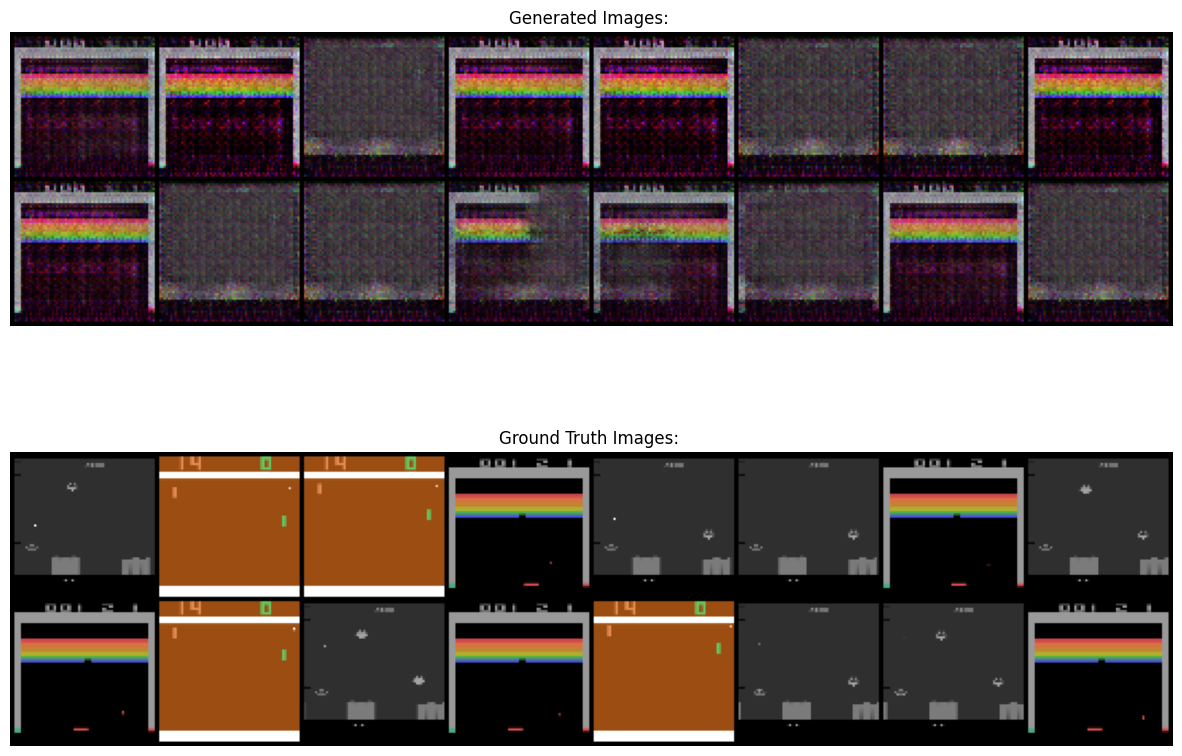

INFO: 30000 在 14.58秒内完成: 生成器损失=7.103972, 判别器损失=0.131428
INFO: 31000 在 14.41秒内完成: 生成器损失=8.239789, 判别器损失=0.100432
INFO: 32000 在 14.08秒内完成: 生成器损失=9.821274, 判别器损失=0.089072
INFO: 33000 在 13.94秒内完成: 生成器损失=7.040260, 判别器损失=0.005894
INFO: 34000 在 14.21秒内完成: 生成器损失=10.755955, 判别器损失=0.002696
INFO: 35000 在 13.98秒内完成: 生成器损失=8.839471, 判别器损失=0.030328
INFO: 36000 在 14.23秒内完成: 生成器损失=11.539289, 判别器损失=0.003672
INFO: 37000 在 14.14秒内完成: 生成器损失=11.595169, 判别器损失=0.019551
INFO: 38000 在 14.13秒内完成: 生成器损失=10.704125, 判别器损失=0.004321
INFO: 39000 在 14.19秒内完成: 生成器损失=7.897098, 判别器损失=0.198330


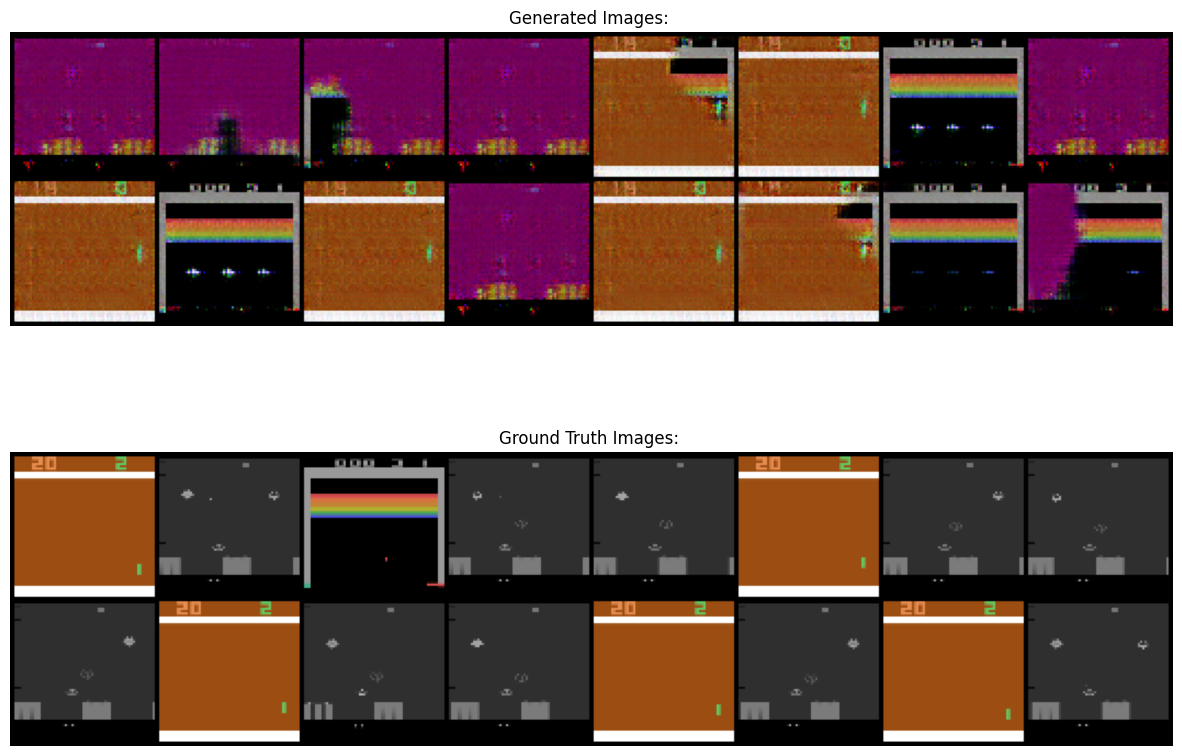

INFO: 40000 在 14.40秒内完成: 生成器损失=10.898187, 判别器损失=0.004241
INFO: 41000 在 14.30秒内完成: 生成器损失=8.761607, 判别器损失=0.001771
INFO: 42000 在 14.20秒内完成: 生成器损失=9.635985, 判别器损失=0.000414
INFO: 43000 在 14.14秒内完成: 生成器损失=8.611213, 判别器损失=0.084985
INFO: 44000 在 14.35秒内完成: 生成器损失=8.765223, 判别器损失=0.007032
INFO: 45000 在 13.99秒内完成: 生成器损失=8.402307, 判别器损失=0.009768
INFO: 46000 在 13.95秒内完成: 生成器损失=7.286041, 判别器损失=0.226247
INFO: 47000 在 14.10秒内完成: 生成器损失=9.554599, 判别器损失=0.003052
INFO: 48000 在 14.24秒内完成: 生成器损失=9.248983, 判别器损失=0.248235
INFO: 49000 在 14.07秒内完成: 生成器损失=8.361731, 判别器损失=0.002156


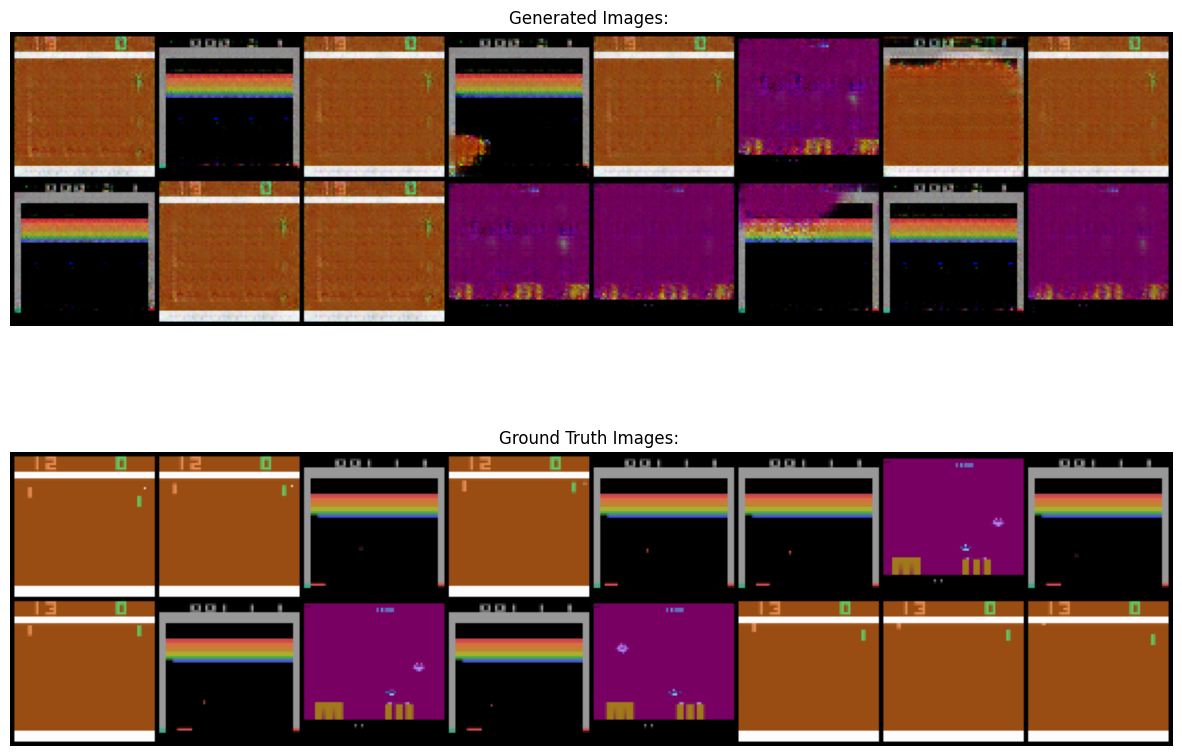

INFO: 50000 在 14.29秒内完成: 生成器损失=8.790890, 判别器损失=0.092014


In [56]:
# 运行训练引擎
try:
    engine.run(data=iterate_batches(envs), max_epochs=1)
except KeyboardInterrupt:
    print("训练被用户中断")

## 生成最终样本

使用训练好的生成器生成一些最终样本并显示。

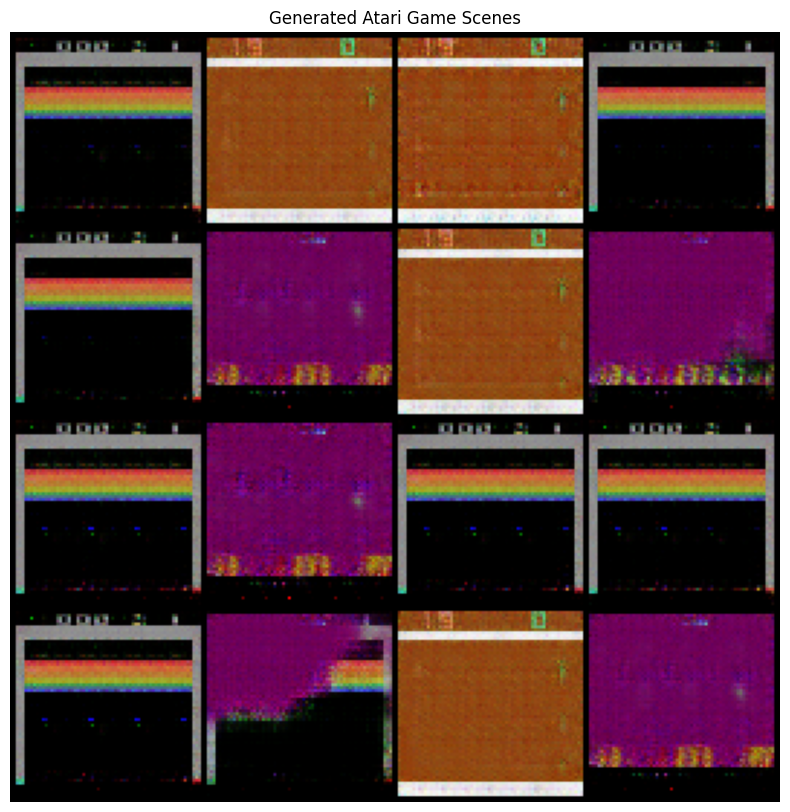

In [57]:
# 生成16个样本
gen_input_v = torch.FloatTensor(16, LATENT_VECTOR_SIZE, 1, 1)
gen_input_v.normal_(0, 1)
gen_input_v = gen_input_v.to(device)

with torch.no_grad():
    gen_output_v = net_gener(gen_input_v)

# 显示生成的图像
plt.figure(figsize=(10, 10))
plt.title("Generated Atari Game Scenes")
img = vutils.make_grid(gen_output_v.data, nrow=4, normalize=True)
plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

## 保存最终模型

保存训练好的生成器和判别器模型，以便将来使用。

In [58]:
# 保存最终模型
torch.save(net_gener.state_dict(), "final_generator.pth")
torch.save(net_discr.state_dict(), "final_discriminator.pth")
print("最终模型已保存")

最终模型已保存


## 清理资源

关闭TensorBoard写入器和游戏环境。

In [59]:
# 关闭TensorBoard写入器
tb.close()

# 关闭环境
for env in envs:
    env.close()

print("训练完成！")

训练完成！


## 总结

在本notebook中，我们使用PyTorch Ignite框架实现了一个生成对抗网络(GAN)，用于生成类似Atari游戏的图像。我们使用了以下几个关键组件：

1. **判别器网络**：用于区分真实图像和生成的图像
2. **生成器网络**：从随机噪声生成类似游戏的图像
3. **PyTorch Ignite引擎**：简化训练循环和事件处理
4. **TensorBoard记录**：记录训练进度和可视化结果

通过这种方式，我们能够生成类似于Breakout、AirRaid和Pong等Atari游戏的图像。